In [6]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect('/Users/Twan/Library/Mobile Documents/com~apple~CloudDocs/Data Science/Data Projects EASI/ENEXIS/src/data/WARP.db')

# Query to get target_datetime and price from master_warp table
df_actual = pd.read_sql_query("""
    SELECT target_datetime, price 
    FROM master_warp
""", conn)

# Convert target_datetime to datetime type
df_actual['target_datetime'] = pd.to_datetime(df_actual['target_datetime'])

# Close the connection
conn.close()

# Display the first few rows to verify the data
print(df_actual.head())

            target_datetime    Price
0 2025-01-01 00:00:00+00:00  0.01362
1 2025-01-01 01:00:00+00:00  0.00624
2 2025-01-01 02:00:00+00:00  0.00416
3 2025-01-01 03:00:00+00:00  0.00328
4 2025-01-01 04:00:00+00:00  0.00068


In [7]:
import pandas as pd
import matplotlib.pyplot as plt


# read the CSV file containing 2025 data
df_predictions = pd.read_csv("random_forest_predictions_with_actuals.csv")


# drop 'prijs_excl_belastingen'
df_predictions = df_predictions.drop(columns=['actual_Price'])
# Convert datetime columns to datetime type
df_predictions['run_date'] = pd.to_datetime(df_predictions['run_date'])
df_predictions['target_datetime'] = pd.to_datetime(df_predictions['target_datetime'])

print(df_predictions.head())

    run_date           target_datetime  predicted_Price
0 2025-03-15 2025-03-16 01:00:00+00:00         0.092295
1 2025-03-15 2025-03-16 02:00:00+00:00         0.091257
2 2025-03-15 2025-03-16 03:00:00+00:00         0.091441
3 2025-03-15 2025-03-16 04:00:00+00:00         0.092581
4 2025-03-15 2025-03-16 05:00:00+00:00         0.092661


In [8]:
def find_cheapest_block_hybrid(actual_df, pred_df, run_date, horizon_days, block_size=4):
    """
    Combine actual and predicted prices to identify the cheapest continuous block
    of `block_size` hours within the horizon starting from `run_date`.
    Returns: dict with info on predicted avg price and mean actual price (if available).
    """
    # Define window start and end
    start_time = pd.Timestamp(run_date).tz_localize('UTC') if pd.Timestamp(run_date).tzinfo is None else pd.Timestamp(run_date)
    end_time = start_time + pd.Timedelta(days=horizon_days)

    # Get actual prices for first 24 hours
    mask_actual = (actual_df['target_datetime'] >= start_time) & (actual_df['target_datetime'] < start_time + pd.Timedelta(hours=24))
    actual_block = actual_df.loc[mask_actual, ['target_datetime', 'Price']].copy()
    actual_block = actual_block.rename(columns={'Price': 'price'})

    # Get predicted prices from 24h onward
    pred_block = pred_df[
        (pred_df['run_date'] == run_date) &
        (pred_df['target_datetime'] >= start_time + pd.Timedelta(hours=24)) &
        (pred_df['target_datetime'] < end_time)
    ][['target_datetime', 'predicted_Price']].copy()
    pred_block = pred_block.rename(columns={'predicted_Price': 'price'})

    # Combine and sort
    combined = pd.concat([actual_block, pred_block]).sort_values('target_datetime').reset_index(drop=True)

    # Check if we have enough data
    if len(combined) < block_size:
        return None

    # Compute rolling means
    rolling_means = combined['price'].rolling(window=block_size).mean()

    # Find minimum
    min_mean = rolling_means.min()
    min_idx = rolling_means.idxmin()

    if pd.notna(min_mean) and min_idx - block_size + 1 >= 0:
        block_start_time = combined.loc[min_idx - block_size + 1, 'target_datetime']
        block_times = pd.date_range(start=block_start_time, periods=block_size, freq='h')

        # Zoek de daadwerkelijke prijzen in df_actual voor deze tijdstippen
        actual_prices_for_block = actual_df[
            actual_df['target_datetime'].isin(block_times)
        ]['Price']

        # Gemiddelde werkelijke prijs berekenen (indien beschikbaar)
        mean_actual_price = actual_prices_for_block.mean() if not actual_prices_for_block.empty else None

        return {
            'run_date': run_date,
            'horizon_days': horizon_days,
            'block_size': block_size,
            'avg_price': min_mean,
            'block_start_time': block_start_time,
            'mean_actual_price': mean_actual_price
        }
    else:
        return None

In [12]:
# Controleer of df_predictions en df_actual bestaan met de juiste kolommen
assert 'run_date' in df_predictions.columns, "Kolom 'run_date' ontbreekt in df_predictions"
assert 'target_datetime' in df_predictions.columns, "Kolom 'target_datetime' ontbreekt in df_predictions"
assert 'predicted_Price' in df_predictions.columns, "Kolom 'predicted_Price' ontbreekt in df_predictions"
assert 'target_datetime' in df_actual.columns, "Kolom 'target_datetime' ontbreekt in df_actual"
assert 'Price' in df_actual.columns, "Kolom 'Price' ontbreekt in df_actual"

# Verzamel resultaten
all_results = []
unique_run_dates = df_predictions['run_date'].dropna().unique()

for run_date in unique_run_dates:
    for horizon in [1, 4, 7]:
        result = find_cheapest_block_hybrid(df_actual, df_predictions, run_date, horizon)
        if result:
            all_results.append(result)

# Omzetten naar DataFrame
results_df = pd.DataFrame(all_results)

# Controleer of de verwachte kolommen aanwezig zijn
required_cols = ['run_date', 'horizon_days', 'block_start_time', 'avg_price', 'mean_actual_price']
missing_cols = [col for col in required_cols if col not in results_df.columns]
assert not missing_cols, f"Ontbrekende kolommen in results_df: {missing_cols}"

# Toon eerste regels met controle op beide prijzen
results_df[required_cols].tail()




,run_date,horizon_days,block_start_time,avg_price,mean_actual_price
184,2025-05-15,4,2025-05-16 11:00:00+00:00,-0.084380,-0.012080
185,2025-05-15,7,2025-05-16 11:00:00+00:00,-0.084380,-0.012080
186,2025-05-16,1,2025-05-16 11:00:00+00:00,-0.012080,-0.012080
187,2025-05-16,4,2025-05-17 11:00:00+00:00,-0.144763,-0.007992
188,2025-05-16,7,2025-05-17 11:00:00+00:00,-0.144763,-0.007992


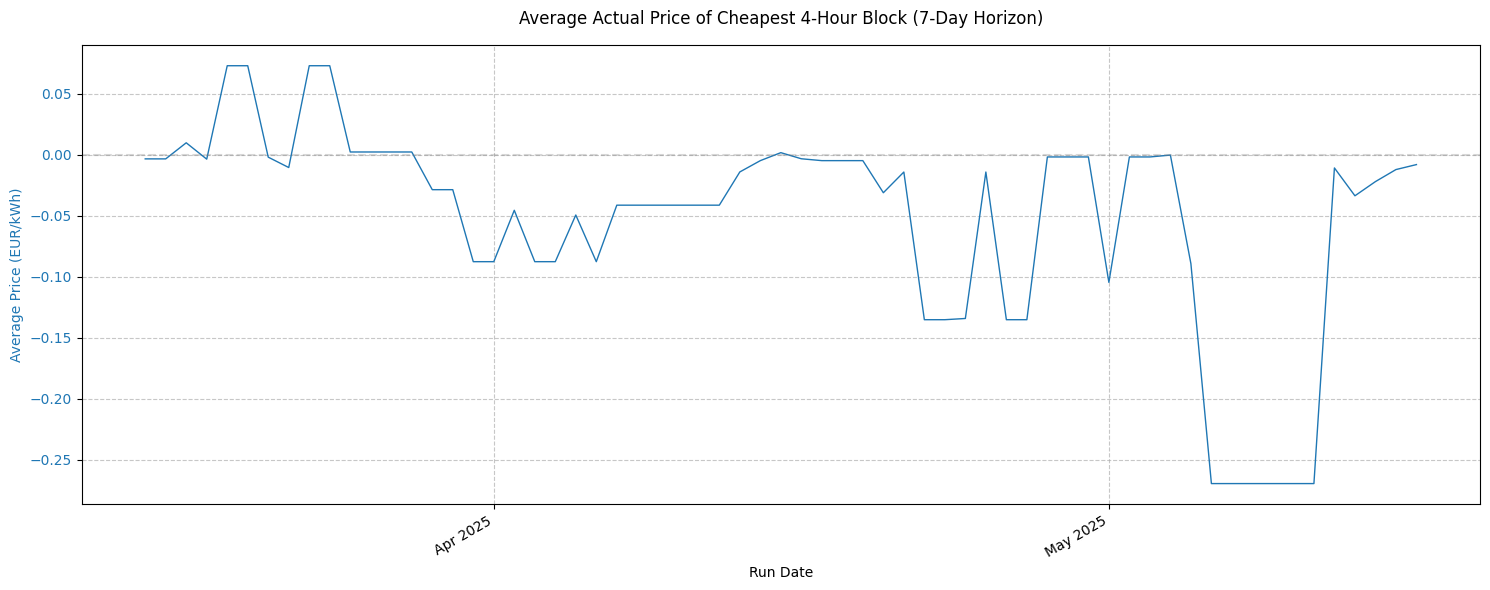

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Filter and sort
horizon7 = results_df[results_df['horizon_days'] == 7].sort_values('run_date')

# Assert required columns exist
assert 'mean_actual_price' in horizon7.columns
assert 'run_date' in horizon7.columns

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot
color1 = 'tab:blue'
ax1.set_xlabel('Run Date')
ax1.set_ylabel('Average Price (EUR/kWh)', color=color1)
ax1.plot(horizon7['run_date'], horizon7['mean_actual_price'], color=color1, linewidth=1)
ax1.tick_params(axis='y', labelcolor=color1)

# Improve date formatting on x-axis
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()

# Decorations
plt.title('Average Actual Price of Cheapest 4-Hour Block (7-Day Horizon)', pad=15)
plt.grid(True, linestyle='--', alpha=0.7)
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

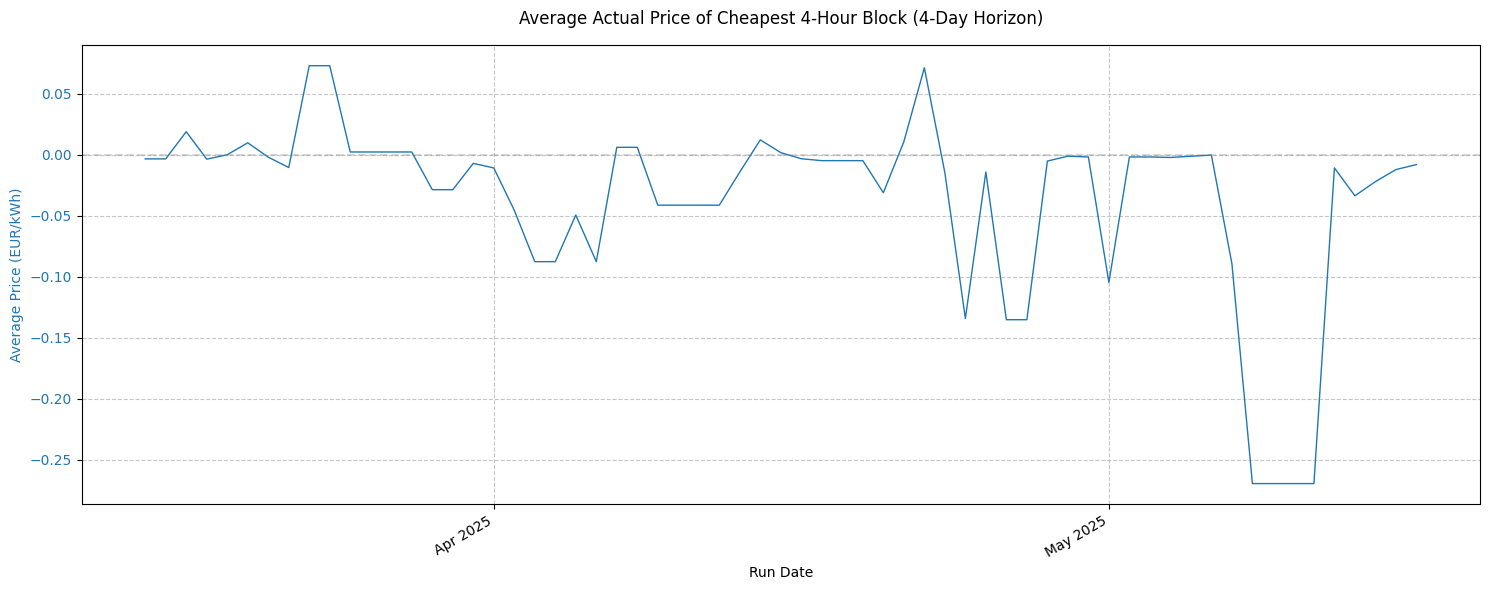

In [17]:
# Filter and sort
horizon4 = results_df[results_df['horizon_days'] == 4].sort_values('run_date')

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot
color1 = 'tab:blue'
ax1.set_xlabel('Run Date')
ax1.set_ylabel('Average Price (EUR/kWh)', color=color1)
ax1.plot(horizon4['run_date'], horizon4['mean_actual_price'], color=color1, linewidth=1)
ax1.tick_params(axis='y', labelcolor=color1)

# Improve date formatting on x-axis
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()

# Decorations
plt.title('Average Actual Price of Cheapest 4-Hour Block (4-Day Horizon)', pad=15)
plt.grid(True, linestyle='--', alpha=0.7)
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

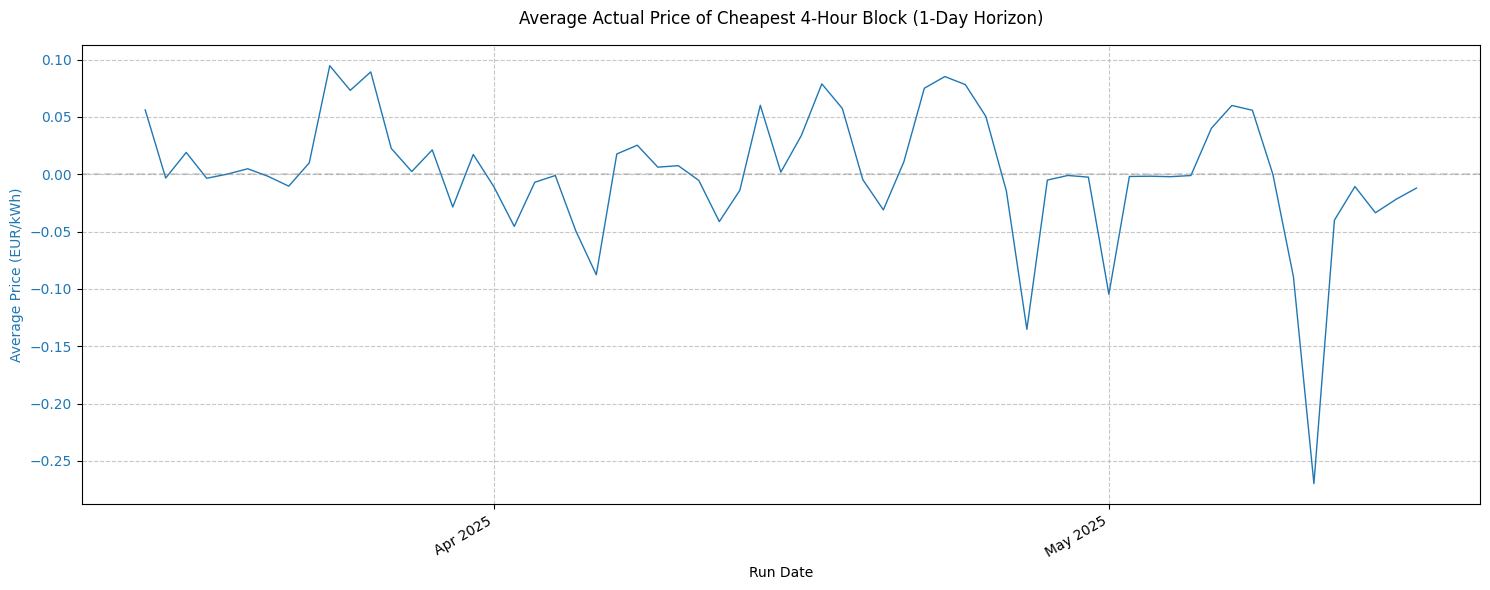

In [18]:
# Filter and sort
horizon1 = results_df[results_df['horizon_days'] == 1].sort_values('run_date')

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot
color1 = 'tab:blue'
ax1.set_xlabel('Run Date')
ax1.set_ylabel('Average Price (EUR/kWh)', color=color1)
ax1.plot(horizon1['run_date'], horizon1['mean_actual_price'], color=color1, linewidth=1)
ax1.tick_params(axis='y', labelcolor=color1)

# Improve date formatting on x-axis
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()

# Decorations
plt.title('Average Actual Price of Cheapest 4-Hour Block (1-Day Horizon)', pad=15)
plt.grid(True, linestyle='--', alpha=0.7)
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# Group by horizon_days and calculate statistics
stats = results_df.groupby('horizon_days')['mean_actual_price'].agg(['mean', 'std']).round(6)

# Add count of blocks
stats['block_count'] = results_df.groupby('horizon_days').size()

# Rename columns for clarity
stats.columns = ['Average Price (EUR/kWh)', 'Standard Deviation', 'Number of Blocks']

print("Statistics per Horizon:")
print("=====================")
print(stats)



Statistics per Horizon:
              Average Price (EUR/kWh)  Standard Deviation  Number of Blocks
horizon_days                                                               
1                             0.00095            0.057120                63
4                            -0.03488            0.074549                63
7                            -0.05120            0.086293                63


In [22]:
# Get baseline price (1-day horizon)
baseline_price = stats.loc[1, 'Average Price (EUR/kWh)']

# Calculate differences and savings
comparison_df = pd.DataFrame(index=[4, 7])
comparison_df['Price Difference (EUR/kWh)'] = stats['Average Price (EUR/kWh)'].loc[[4, 7]] - baseline_price
comparison_df['Annual Savings (EUR)'] = comparison_df['Price Difference (EUR/kWh)'] * -2500  # Negative to show savings as positive

# Display results
print("Baseline price (1-day horizon): {:.5f} EUR/kWh".format(baseline_price))
print("\nComparison with longer horizons:")
print(comparison_df)

Baseline price (1-day horizon): 0.00095 EUR/kWh

Comparison with longer horizons:
   Price Difference (EUR/kWh)  Annual Savings (EUR)
4                    -0.03583                89.575
7                    -0.05215               130.375
